BERT classification example.

Based on https://habr.com/ru/articles/567028/

Tested in Google Colab. HF_TOKEN is required to download the model.

# Imports and settings

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import transformers
import torch
from torch.utils.data import Dataset, DataLoader
import time
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Obtain data

## get raw data

In [ ]:
import urllib.request as request

# obtain Amazon cell phone review dataset via link
request.urlretrieve('https://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz', filename='data.gz')

('data.gz', <http.client.HTTPMessage at 0x7ff98d469110>)

In [ ]:
# parse .gz to pandas DataFrame
import gzip

def gzip_reader(path):
  for line in gzip.open(path, 'rb'):
    yield eval(line) # evaluate a line to get a dict

record_dict = {} # key = index; values = dict of {column : value}

for i, d in enumerate(gzip_reader('data.gz')):
  record_dict[i] = d

df_data = pd.DataFrame.from_dict(record_dict, orient='index')
# df_data.head()

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194439 entries, 0 to 194438
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      194439 non-null  object 
 1   asin            194439 non-null  object 
 2   reviewerName    190920 non-null  object 
 3   helpful         194439 non-null  object 
 4   reviewText      194439 non-null  object 
 5   overall         194439 non-null  float64
 6   summary         194439 non-null  object 
 7   unixReviewTime  194439 non-null  int64  
 8   reviewTime      194439 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 14.8+ MB


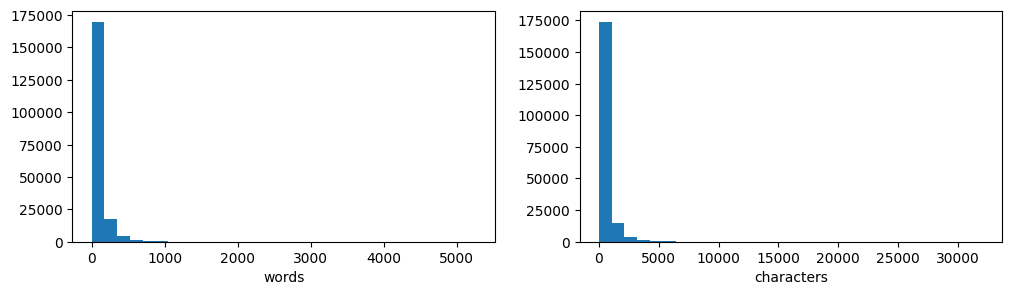

In [ ]:
# is the model appropriate for the task?

_, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,3))

ax0.hist(df_data.reviewText.apply(lambda s : len(s.split())), bins=30)
ax0.set_xlabel('words')

ax1.hist(df_data.reviewText.apply(lambda s : len(s)), bins=30)
ax1.set_xlabel('characters')

plt.show()

In [ ]:
np.quantile(df_data.reviewText.apply(lambda s : len(s.split())), 0.95)

np.float64(307.0)

Most of the texts have 307 or less words. Therefore distilbert's max_len of 512 tokens should be enough.

# Utilities

In [ ]:
class BertDataset(Dataset):
  "Custom class for use with BERT"

  def __init__(self, texts, targets, tokenizer, max_len=512):
    """ texts and targets can be lists, arrays or pandas Series
    """
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

    self._tf_pandas_texts   = isinstance(self.texts, pd.DataFrame)   or isinstance(self.texts, pd.Series)
    self._tf_pandas_targets = isinstance(self.targets, pd.DataFrame) or isinstance(self.targets, pd.Series)

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text   = str(self.texts.iloc[idx]   if self._tf_pandas_texts   else self.texts[idx])
    target = self.targets.iloc[idx] if self._tf_pandas_targets else self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True, # truncate long texts
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype=torch.long)
    }


class BertClassifier:
  """ Classification model and train pipeline.
  """

  def __init__(
      self,
      model_path,
      n_classes=2,
      max_len=512,
      loss_fn=torch.nn.CrossEntropyLoss(),
      optimizer=None,
      scheduler=None,
      epochs=1,
      batch_size=30,
      debug_max_batch=np.inf,
      seed=0
      ):

    self.model_path = model_path
    self.n_classes = n_classes
    self.max_len = max_len
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.epochs = epochs
    self.batch_size = batch_size
    self.debug_max_batch = debug_max_batch
    self.seed = seed

    self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_path)
    self.base_model = transformers.DistilBertForSequenceClassification.from_pretrained(self.model_path)

    # classification head
    self.out_features = self.base_model.classifier.in_features
    self.base_model.classifier = torch.nn.Linear(self.out_features, self.n_classes)
    # self.base_model.classifier = torch.nn.Sequential(OrderedDict([
    #     ('clf_dense1', torch.nn.Linear(self.out_features, self.out_features * 2)),
    #     ('clf_dense2', torch.nn.Linear(self.out_features * 2, self.n_classes))
    #     ]))

    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.base_model.to(self.device)

    # to encode targets as integers
    self.label_encoder = LabelEncoder()

    if self.optimizer is None:
      self.optimizer = torch.optim.AdamW(self.base_model.parameters(), lr=2e-5)


  def prepare_datasets(self, texts, targets, test_size=0.2, batch_size=None):
    """ Pipeline for the data.
    Creates train, val and test dataloaders.
    """

    # assume that targets contains all possible labels
    # and train label encoder to convert targets to int
    targets = self.label_encoder.fit_transform(targets)

    assert self.n_classes == len(self.label_encoder.classes_)

    X_train, X_val, y_train, y_val = train_test_split(texts, targets, test_size=test_size, stratify=targets, random_state=self.seed)

    self.set_train = BertDataset(X_train, y_train, self.tokenizer, max_len=self.max_len)
    self.set_val   = BertDataset(X_val,   y_val,   self.tokenizer, max_len=self.max_len)
    self.set_test  = BertDataset(X_val,   y_val,   self.tokenizer, max_len=self.max_len) # test = val for now

    if self.batch_size is None:
      n = len(X_train)
    elif self.batch_size >= 1:
      n = int(self.batch_size)
    else:
      n = int(self.batch_size * len(X_train))

    self.loader_train = DataLoader(self.set_train, batch_size=n, shuffle=True)
    self.loader_val   = DataLoader(self.set_val,   batch_size=n, shuffle=True)
    self.loader_test  = DataLoader(self.set_test,  batch_size=n, shuffle=True)


  def train_model(self):
    """
    Cycles throu epochs.
    For each epoch, fits on train dataset, evaluates on val dataset
    and displays aggregate statistics.

    Returns a dict of metrics per epoch.
    """

    start_time = time.time()
    loss_prev = np.nan

    metrics_epoch = {}
    metrics_epoch['accuracy_train'] = []
    metrics_epoch['loss_train'] = []
    metrics_epoch['accuracy_val'] = []
    metrics_epoch['loss_val'] = []

    print('----------------------------------------------------------------------------------------------')
    print('| epoch | training_loss | loss decrease | training accuracy | validation accuracy |   time   |')
    print('----------------------------------------------------------------------------------------------')

    for epoch in range(self.epochs):

      metrics_agg_train, _ = self.fit()
      metrics_agg_val, _ = self.eval()

      s = '| {0:5d} | {1:13.8f} | {2:12.6f}% | {3:16.6f}% | {4:18.6f}% | {5:7.2f}s |'.format(
          epoch,
          metrics_agg_train['loss_avg'],
          (metrics_agg_train['loss_avg'] - loss_prev) / (1e-12 + loss_prev) * 100,
          metrics_agg_train['accuracy_avg'] * 100,
          metrics_agg_val['accuracy_avg'] * 100,
          time.time() - start_time
          )

      print(s)

      loss_prev = metrics_agg_train['loss_avg']

      metrics_epoch['accuracy_train'].append(metrics_agg_train['accuracy_avg'])
      metrics_epoch['loss_train'].append(metrics_agg_train['loss_avg'])
      metrics_epoch['accuracy_val'].append(metrics_agg_val['accuracy_avg'])
      metrics_epoch['loss_val'].append(metrics_agg_val['loss_avg'])

    print('----------------------------------------------------------------------------------------------')

    return metrics_epoch


  def fit(self):

    metrics_batch = {}
    metrics_batch['num_preds_correct'] = []
    metrics_batch['num_preds'] = []
    metrics_batch['accuracy'] = []
    metrics_batch['loss'] = []

    # switch model to train mode
    self.base_model.train(True)

    for n_batch, data in enumerate(self.loader_train):
      # if n_batch % 10 == 0: print(n_batch)

      self.optimizer.zero_grad()

      # BATCH_SIZE vectors
      input_ids = data['input_ids'].to(self.device)
      attention_mask = data['attention_mask'].to(self.device)
      y_true = data['targets'].to(self.device)

      # outputs.logits is BATCH_SIZE x N_CLASSES matrix
      outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)

      # y_pred is BATCH_SIZE vector
      y_pred = torch.argmax(outputs.logits, dim=1)

      loss = self.loss_fn(outputs.logits, y_true)

      # get the batch metrics
      metrics_batch['loss'].append(loss.item())

      n_true = torch.sum(y_pred == y_true).item()
      metrics_batch['num_preds_correct'].append( n_true )
      metrics_batch['num_preds'].append( y_pred.shape[0] )
      metrics_batch['accuracy'].append( n_true / y_pred.shape[0] )

      # optimization step
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.base_model.parameters(), max_norm=1.0)
      self.optimizer.step()

      if self.scheduler is not None:
        self.scheduler.step()

      if n_batch > self.debug_max_batch: break

    # get aggregate metrics over all batches
    metrics_batch_agg = {
        'accuracy_avg' : np.sum(metrics_batch['num_preds_correct']) / (0.5 + np.sum(metrics_batch['num_preds'])),
        # 'accuracy_std' : np.std(metrics_batch['accuracy']),
        'loss_avg' :     np.mean(metrics_batch['loss']),
        'loss_std' :     np.std(metrics_batch['loss'])
    }

    return metrics_batch_agg, metrics_batch


  def eval(self):

    metrics_batch = {}
    metrics_batch['num_preds_correct'] = []
    metrics_batch['num_preds'] = []
    metrics_batch['accuracy'] = []
    metrics_batch['loss'] = []

    # switch model to inference mode
    self.base_model.train(False)

    with torch.no_grad():
      for n_batch, data in enumerate(self.loader_train):
        # if n_batch % 10 == 0: print(n_batch)

        self.optimizer.zero_grad()

        # BATCH_SIZE vectors
        input_ids = data['input_ids'].to(self.device)
        attention_mask = data['attention_mask'].to(self.device)
        y_true = data['targets'].to(self.device)

        # outputs.logits is BATCH_SIZE x N_CLASSES matrix
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)

        # y_pred is BATCH_SIZE vector
        y_pred = torch.argmax(outputs.logits, dim=1)

        loss = self.loss_fn(outputs.logits, y_true)

        # get the batch metrics
        metrics_batch['loss'].append(loss.item())

        n_true = torch.sum(y_pred == y_true).item()
        metrics_batch['num_preds_correct'].append( n_true )
        metrics_batch['num_preds'].append( y_pred.shape[0] )
        metrics_batch['accuracy'].append( n_true / y_pred.shape[0] )

        if n_batch > self.debug_max_batch: break

    # get aggregate metrics over all batches
    metrics_batch_agg = {
        'accuracy_avg' : np.sum(metrics_batch['num_preds_correct']) / (0.5 + np.sum(metrics_batch['num_preds'])),
        # 'accuracy_std' : np.std(metrics_batch['accuracy']),
        'loss_avg' :     np.mean(metrics_batch['loss']),
        'loss_std' :     np.std(metrics_batch['loss'])
    }

    return metrics_batch_agg, metrics_batch


# Model training

In [ ]:
n_classes = np.unique(df_data.overall).shape[0]

model = BertClassifier(
    'distilbert-base-uncased',
    n_classes=n_classes,
    epochs=100,
    batch_size=10,
    debug_max_batch=100, # end epoch after this number of batches, used to track metrics
    seed=0
    )

model.prepare_datasets(df_data.reviewText, df_data.overall)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# # burn in period
# model.epochs = 1
# model.optimizer = torch.optim.AdamW(model.base_model.parameters(), lr=1e-3)

# metrics_epoch = model.train_model()

In [ ]:
# train
n_batches_per_epoch = min(model.debug_max_batch, len(model.loader_train))

model.optimizer = torch.optim.AdamW(model.base_model.parameters(), lr=3e-5)

model.scheduler = transformers.get_linear_schedule_with_warmup(
                model.optimizer,
                num_warmup_steps=n_batches_per_epoch, # burn in period
                num_training_steps= n_batches_per_epoch * model.epochs
            )

metrics_epoch = model.train_model()

----------------------------------------------------------------------------------------------
| epoch | training_loss | loss decrease | training accuracy | validation accuracy |   time   |
----------------------------------------------------------------------------------------------
|     0 |    1.32074507 |          nan% |        49.975502% |          56.834885% |   56.20s |
|     1 |    1.03557948 |   -21.591267% |        58.304753% |          63.400294% |  112.49s |
|     2 |    0.93783744 |    -9.438391% |        63.106320% |          66.731994% |  169.37s |
|     3 |    0.91796594 |    -2.118864% |        63.694268% |          63.008329% |  226.55s |
|     4 |    0.90475733 |    -1.438900% |        62.518373% |          63.792259% |  284.17s |
|     5 |    0.91897726 |     1.571684% |        63.400294% |          62.126409% |  341.84s |
|     6 |    0.92497432 |     0.652579% |        60.754532% |          68.691818% |  399.60s |
|     7 |    0.84124487 |    -9.052083% |        6

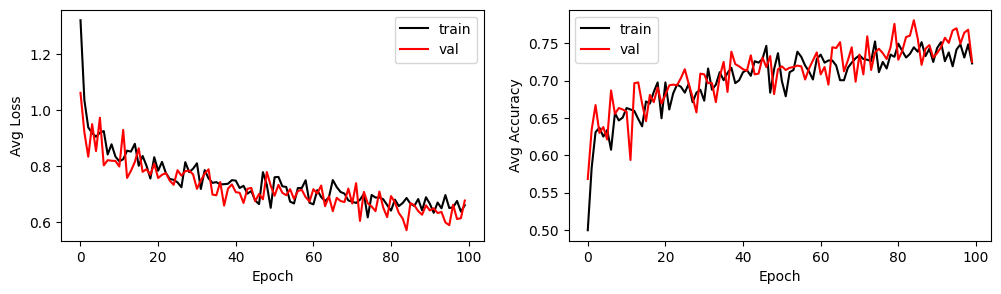

In [ ]:
_, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 3))

ax0.plot(metrics_epoch['loss_train'], '-k', label='train')
ax0.plot(metrics_epoch['loss_val'], '-r', label='val')
ax0.set(
    xlabel='Epoch',
    ylabel='Avg Loss'
)
ax0.legend()

ax1.plot(metrics_epoch['accuracy_train'], '-k', label='train')
ax1.plot(metrics_epoch['accuracy_val'], '-r', label='val')
ax1.set(
    xlabel='Epoch',
    ylabel='Avg Accuracy'
)
ax1.legend()

plt.show()

In [ ]:
# final evaluation: calculate accuracy over all eval dataset

model.debug_max_batch = np.inf
metrics, _ = model.eval()

In [ ]:
metrics

{'accuracy_avg': np.float64(0.7441844019504794),
 'loss_avg': np.float64(0.6458684407480159),
 'loss_std': np.float64(0.2766232930249961)}

# -------

In [ ]:
# data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# import inspect
# lines = inspect.getsource(transformers.DataCollatorWithPadding)
# print(lines)